# Data augmentation for self-driving cars

This notebook is a playground for various data augmentation routines like horizon estimation, viewpoint transformation and Ackermann kinematics. The algorithms tested here will be available as a separate python script to be used in the training pipeline.

In [6]:
%reload_ext autoreload
%autoreload 2
import cv2
import numpy as np
import augmentation as aug
import os
import math
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.animation as animation
# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

## Loading a random image

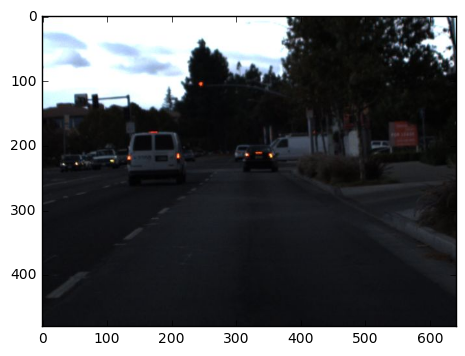

In [3]:
#image_folders = ['data/dataset-20160929/center_camera', 'data/dataset-20160929/left_camera', 'data/dataset-20160929/right_camera']
image_folders = ['data/train/1/center', 'data/train/1/left', 'data/train/1/right']
images = os.listdir(image_folders[0])

img = cv2.imread(os.path.join(image_folders[0], np.random.choice(images)))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

## Estimating horizon

We use Canny edge detector and Hough transform get the best estimation for horizon line.

Horizon y: 200


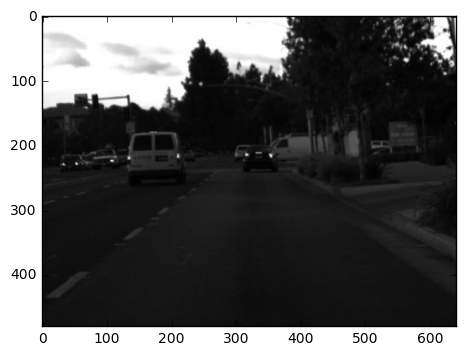

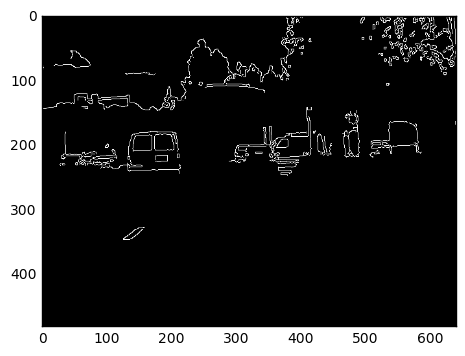

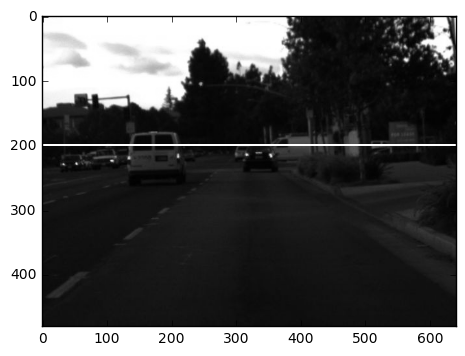

In [4]:
print('Horizon y: {}'.format(aug.get_horizon_y(img, min_y=200, max_y=300, draw=True)))

## Rotation and shift

"*Additional shifts between the cameras and all rotations are simulated by viewpoint transformation of the image from the nearest camera. Precise viewpoint transformation requires 3D scene knowledge which we don’t have. We therefore approximate the transformation by assuming all points below the horizon are on flat ground and all points above the horizon are infinitely far away. This works fine for flat terrain but it introduces distortions for objects that stick above the ground, such as cars, poles, trees, and buildings. Fortunately these distortions don’t pose a big problem for network training.*"

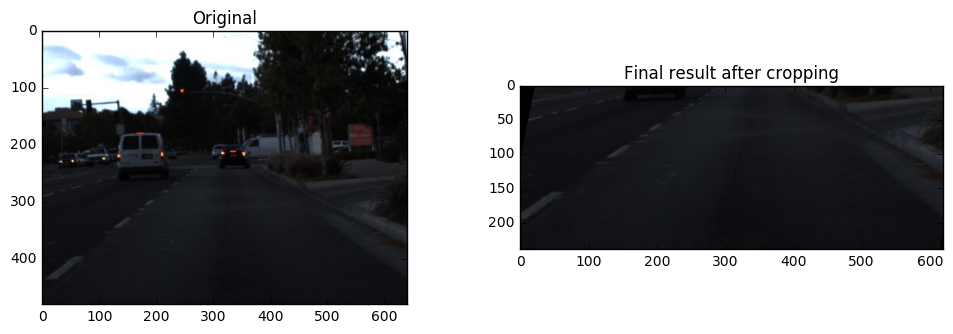

In [33]:
distorted = aug.apply_distortion(img, 0.01, 0.1, crop_y=240, draw=True)

### Testing rotation

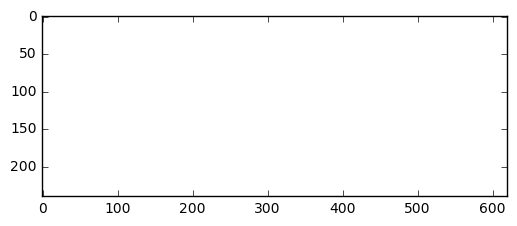

In [34]:
def get_animation(frames, file=None, fps=20, repeat_delay=1000):
    fig = plt.figure()
    ims = []

    for f in frames:
        im = plt.imshow(f, animated=True)
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=(1/fps)*1000, repeat_delay=repeat_delay)
    
    if file is not None:
        ani.save('rotation_shift.mp4')
    
    return ani

angs = np.append(np.linspace(0., -0.01, 20), np.linspace(-0.01, 0., 20))
angs = np.append(angs, np.linspace(0., 0.01, 20))
angs = np.append(angs, np.linspace(0.01, 0., 20))

ani = get_animation([aug.apply_distortion(img, ang, 0) for ang in angs])
HTML(ani.to_html5_video())

### Testing shift

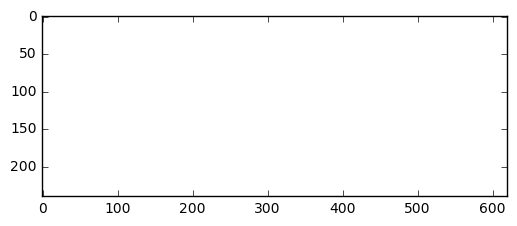

In [35]:
shifts = np.append(np.linspace(0, -0.1, 20), np.linspace(-0.1, 0, 20))
shifts = np.append(shifts, np.linspace(0, 0.1, 20))
shifts = np.append(shifts, np.linspace(0.1, 0, 20))

ani = get_animation([aug.apply_distortion(img, 0, shift) for shift in shifts])
HTML(ani.to_html5_video())

### Testing rotation and shift

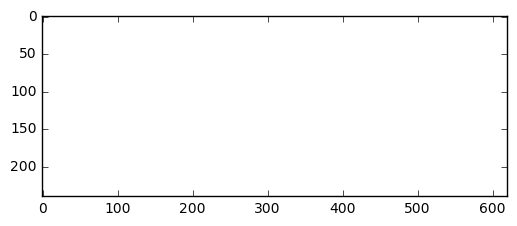

In [36]:
ani = get_animation([aug.apply_distortion(img, angs[i], shifts[i]) for i in range(len(shifts))])
HTML(ani.to_html5_video())

### Random distortions

"*After selecting the final set of frames we augment the data by adding artificial shifts and rotations to teach the network how to recover from a poor position or orientation. The magnitude of these perturbations is chosen randomly from a normal distribution. The distribution has zero mean, and the standard deviation is twice the standard deviation that we measured with human drivers. Artificially augmenting the data does add undesirable artifacts as the magnitude increases*"

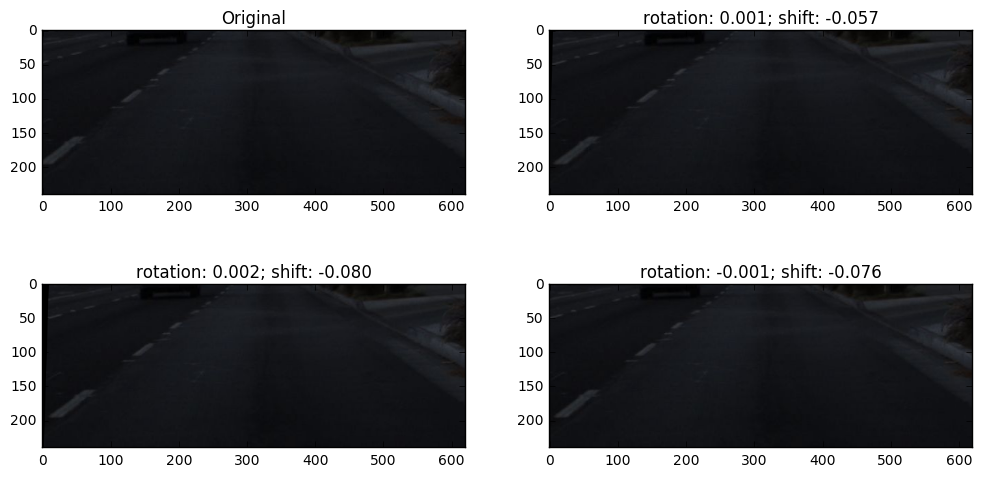

In [37]:
fig = plt.figure(figsize=(12, 6))
fig.add_subplot(221, title="Original")
plt.imshow(aug.apply_distortion(img, 0, 0))

for i in range(2,5):
    distorted, rotation, shift = aug.random_distortion(img)
    fig.add_subplot(2, 2, i, title="rotation: {:.3f}; shift: {:.3f}".format(rotation, shift))
    plt.imshow(distorted)


## Pixel - distance equivalence

We know that the cameras are ~ 50cm apart. How much shift in pixels this distance correspond?

* Left camera ~ 100 pixels
* Right camera ~ 60 pixels

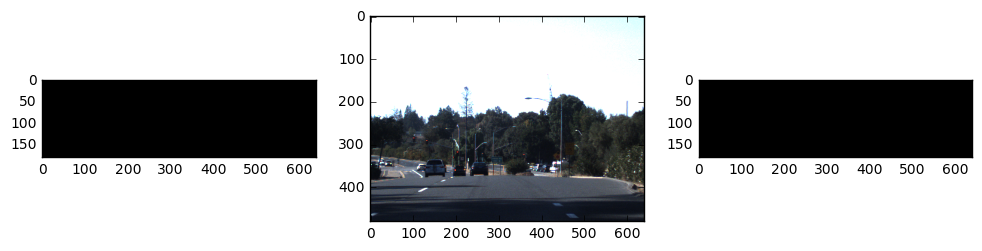

In [23]:
#image_folders = ['data/center_camera', 'data/left_camera', 'data/right_camera']
images = os.listdir(image_folders[0])
choice = np.random.choice(images)
img_center = cv2.imread(os.path.join(image_folders[0], choice))
img_left = cv2.imread(os.path.join(image_folders[1], choice))
img_right = cv2.imread(os.path.join(image_folders[2], choice))
img_center = cv2.cvtColor(img_center, cv2.COLOR_BGR2RGB)
img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB)
img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(12, 12))
fig.add_subplot(1, 3, 1)
plt.imshow(apply_distortion(img_left, 0, 100, crop=False))
fig.add_subplot(1, 3, 2)
plt.imshow(img_center)
fig.add_subplot(1, 3, 3)
plt.imshow(apply_distortion(img_right, 0, -60, crop=False))

## Ackermann kinematics

"*The steering label for transformed images is adjusted to one that would steer the vehicle back to the desired location and orientation in two seconds.*"

Formulas for position in world coordinates:

$\begin{align}
\dot{x}_w=\cos{\theta_w}\dot{x}_r \\
\dot{y}_w=\sin{\theta_w}\dot{x}_r \\
\dot{\theta}_w=\frac{\tan{\phi}}{L}\dot{x}_r
\end{align}$

See http://correll.cs.colorado.edu/?p=1869 for more details.

In [38]:
import pandas as pd

center_steering = pd.read_csv('data/dataset-20160929/center_steering.csv')
left_steering = pd.read_csv('data/dataset-20160929/left_steering.csv')

-0.478141206981 -0.008135847486288705 -0.023704199884981556 0.045378562063
-0.418406209304 -0.013928796169035085 -0.036926231069972594 -0.00324601335311
-0.341981570789 -0.016089342742067636 -0.004029679328534318 0.00349065847695
-0.262667274127 -0.015785242207932093 0.030507349555355823 0.0209439508617
-0.188705041399 -0.013972836610145922 0.03624417051332504 0.0174532923847
-0.125180058753 -0.011449988175332049 0.0429020062488034 0.0209873309531
-0.0742398586747 -0.008773935765620244 0.08915078297997799 0.0678881047956
-0.0358275452315 -0.006282100519899414 0.07811959039189185 0.059656533156
-0.00896210167037 -0.004164720307342495 0.037576378595168734 0.0226892810315
0.00819865082719 -0.0024901918365918263 0.0007376183604108231 -0.0104719754308
0.0177839656329 -0.0012504537372934887 -0.0029329783823670436 -0.010816389978
0.0218143580201 -0.0003944940283184817 -0.001827623571445051 -0.0069813169539
0.0220809313189 0.00014738191016738789 -0.01964364387035695 -0.0226892810315
0.02004254

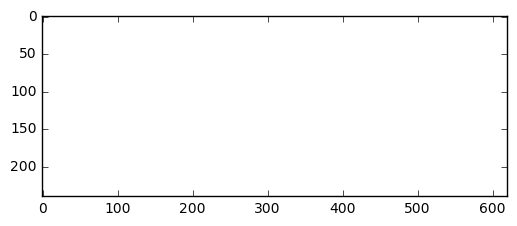

In [45]:
def imread_rgb(path):
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#i = 100
i = np.random.choice(range(500))
fps = 20

imgs_left = []        
f = 0
images = os.listdir(image_folders[1])
while f <= 2 * fps:    
    img_left = imread_rgb(os.path.join(image_folders[1], images[i + f]))
    imgs_left.append(aug.apply_distortion(img_left, 0, 0))

    f = f + 1

i = i + f
    
shift0 = -.5
rotation0 = 0.
shift = shift0
rotation = rotation0

while abs(shift) > 0.005 or abs(rotation) > 0.001:

    img_left = imread_rgb(os.path.join(image_folders[1], images[i]))
    
    speed = left_steering.iloc[i].speed
    steering_wheel_angle = left_steering.iloc[i].steering_wheel_angle
    rotation, shift, steering_wheel_angle = aug.get_steer_back_angle(steering_wheel_angle, speed, rotation, shift)
    imgs_left.append(aug.apply_distortion(img_left, (rotation - rotation0), (shift - shift0)))
    
    if i % 10 == 0:
        print(shift, rotation, steering_wheel_angle, left_steering.iloc[i].steering_wheel_angle)
        
    i = i + 1
        
ani = get_animation(imgs_left, fps=fps)
HTML(ani.to_html5_video())

In [215]:
ani.save('steering.mp4')

### Combining distortions and steer back calculations

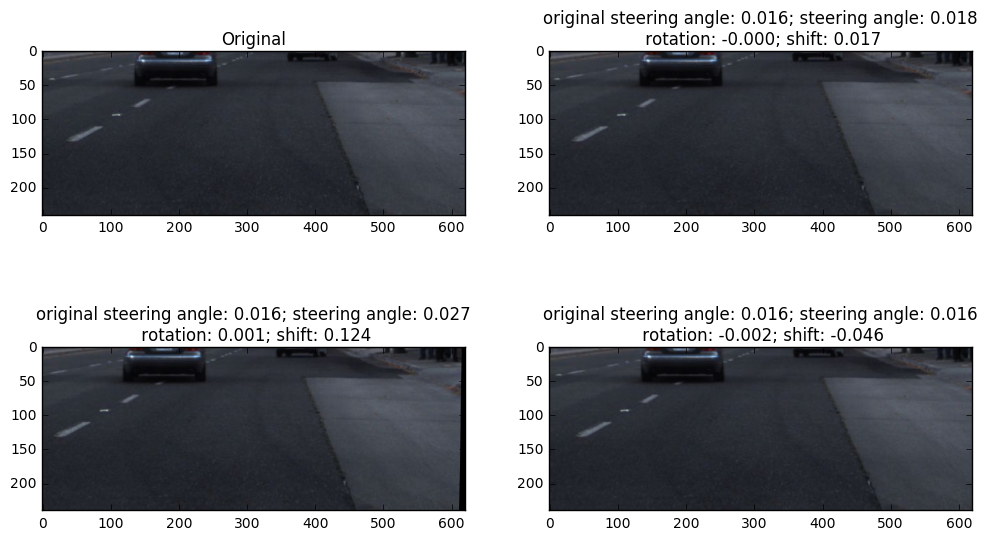

In [41]:
images = os.listdir(image_folders[0])
choice = np.random.choice(range(len(images)))
img_center = cv2.imread(os.path.join(image_folders[0], images[choice]))
image = cv2.cvtColor(img_center, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(12, 7))
fig.add_subplot(221, title="Original")
plt.imshow(aug.apply_distortion(image, 0, 0))

for i in range(2,5):
    speed = left_steering.iloc[choice].speed
    
    if speed == 0:
        continue
        
    original_steering_wheel_angle = left_steering.iloc[choice].steering_wheel_angle
    distorted, steering_wheel_angle, rotation, shift = aug.steer_back_distortion(image, 
                                                                             original_steering_wheel_angle,
                                                                             speed)
    fig.add_subplot(2, 2, i, title="original steering angle: {:.3f}; steering angle: {:.3f}\n rotation: {:.3f}; shift: {:.3f}"
                    .format(original_steering_wheel_angle, steering_wheel_angle, rotation, shift))
    plt.imshow(distorted)